In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from utilities import read_xml, plot_two, plot_three
from neo4j import GraphDatabase
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier


D:\Programme\miniconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import
PATH_DEV = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_dev.txt')
PATH_TEST = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_test.txt')
PATH_TRAIN = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_train.txt')

df_train = read_xml(PATH_TRAIN)
df_test = read_xml(PATH_TEST)
df_dev = read_xml(PATH_DEV)

frames = [df_train, df_test, df_dev]
df = pd.concat(frames).reset_index(drop=True)

# Exploring the Dataset

In [3]:
df.head()

,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE
0,The New York Times Daily Crossword Puzzles: Th...,New York Times,"Dec 28, 1996",9780804115827,224 Pages,https://www.penguinrandomhouse.com/books/12309...,"Nonfiction, Games",(c) Penguin Random House,Monday’s Crosswords Do with EaseTuesday’s Cros...,2018-08-18,en
1,Creatures of the Night (Second Edition),Neil Gaiman,"Nov 29, 2016",9781506700250,48 Pages,https://www.penguinrandomhouse.com/books/53958...,"Fiction, Graphic Novels Manga",(c) Penguin Random House,Two of literary comics modern masters present ...,2018-08-18,en
2,Cornelia and the Audacious Escapades of the So...,Lesley M. M. Blume,"Jan 08, 2008",9780440421108,272 Pages,https://www.penguinrandomhouse.com/books/15160...,"Children’s Books, Children’s Middle Grade Books",(c) Penguin Random House,Eleven-year-old Cornelia is the daughter of tw...,2018-08-18,en
3,The Alchemist's Daughter,Katharine McMahon,"Oct 24, 2006",9780307335852,352 Pages,https://www.penguinrandomhouse.com/books/11223...,"Fiction, Historical Fiction",(c) Penguin Random House,"During the English Age of Reason, a woman cloi...",2018-08-18,en
4,Dangerous Boy,Mandy Hubbard,"Aug 30, 2012",9781101575017,272 Pages,https://www.penguinrandomhouse.com/books/30534...,"Teen Young Adult, Teen Young Adult Mystery ...",(c) Penguin Random House,A modern-day retelling of The Strange Case of ...,2018-08-18,en


In [4]:
# Basic Statistic
print('Number of datasets: ', df.shape[0])
print('Number of columns: ', df.shape[1])
print('Columns: ', ', '.join(df.columns))

Number of datasets:  91894
Number of columns:  11
Columns:  TITLE, AUTHOR, PUBLISHED, ISBN, PAGE_NUM, URL, TOPICS, COPYRIGHT, DESCRIPTION, DATE, LANGUAGE


In [5]:
# Extracting Information
# Number of Authors, Copyright

# Number of Authors
print('Number of Authors: ', df['AUTHOR'].nunique())

# Number of Copyright
print('Number of Copyright: ', df['COPYRIGHT'].nunique())
print('Different Copyrights: ', df['COPYRIGHT'].unique())

# Number of Language
print('Number of Language: ', df['LANGUAGE'].nunique())
print('Different Langauge: ', df['LANGUAGE'].unique())

Number of Authors:  35928
Number of Copyright:  2
Different Copyrights:  ['(c) Penguin Random House' '(c) 2018 Penguin Random House']
Number of Language:  1
Different Langauge:  ['en']


In [6]:
# Extract Data
df['PAGE_NUM'] = df['PAGE_NUM'].str.extract('(\d+)').astype(int)
df['PUBLISHED'] = df['PUBLISHED'].str.extract(r'(\d{4})').astype(int)
df['TOPIC_COUNT'] = df['TOPICS'].str.split(',').apply(lambda x: len(x))

In [7]:
df.describe()

,PUBLISHED,PAGE_NUM,TOPIC_COUNT
count,91894.000000,91894.000000,91894.000000
mean,2008.610649,277.134655,3.024060
std,8.137799,201.229372,1.407657
min,1929.000000,1.000000,1.000000
25%,2005.000000,160.000000,2.000000
50%,2011.000000,272.000000,3.000000
75%,2015.000000,352.000000,4.000000
max,2019.000000,5392.000000,11.000000


Most common Authors: 
AUTHOR
DK                                 1022
Various                             445
Golden Books                        251
Louis L'Amour                       234
Random House                        234
DK Travel                           228
Tabor Evans                         200
Nora Roberts                        187
Jake Logan                          184
Jon Sharpe                          164
Dr. Seuss                           159
William Shakespeare                 159
RH Disney                           159
Princeton Review                    157
Wesley Ellis                        152
Living Language                     149
National Geographic Kids            144
David A. Adler                      122
Danielle Steel                      119
Bonnie Bryant                       111
Nancy Krulik                        107
Roger Hargreaves                    105
Robert B. Parker                    103
Gary Paulsen                        100
Jim Davis  

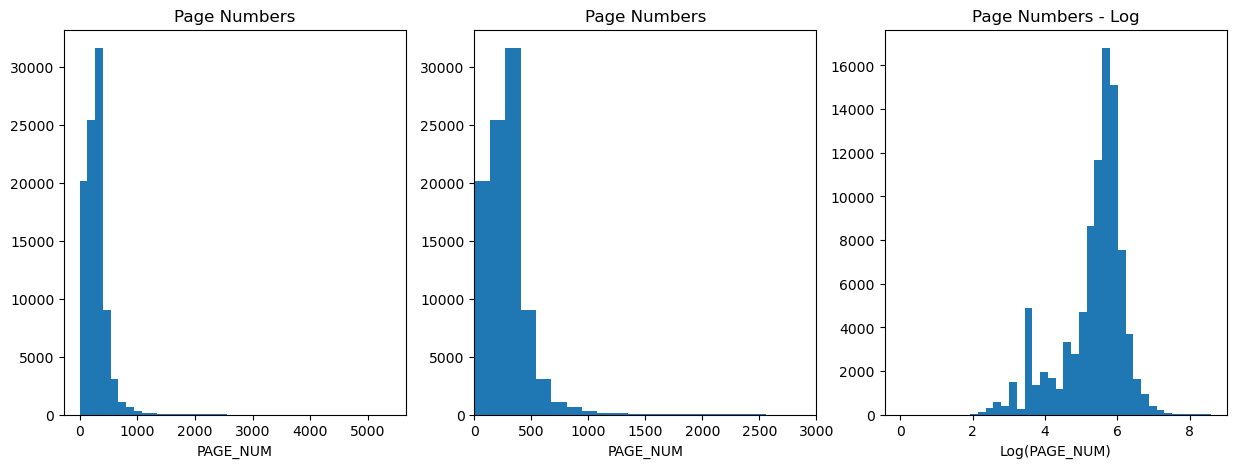

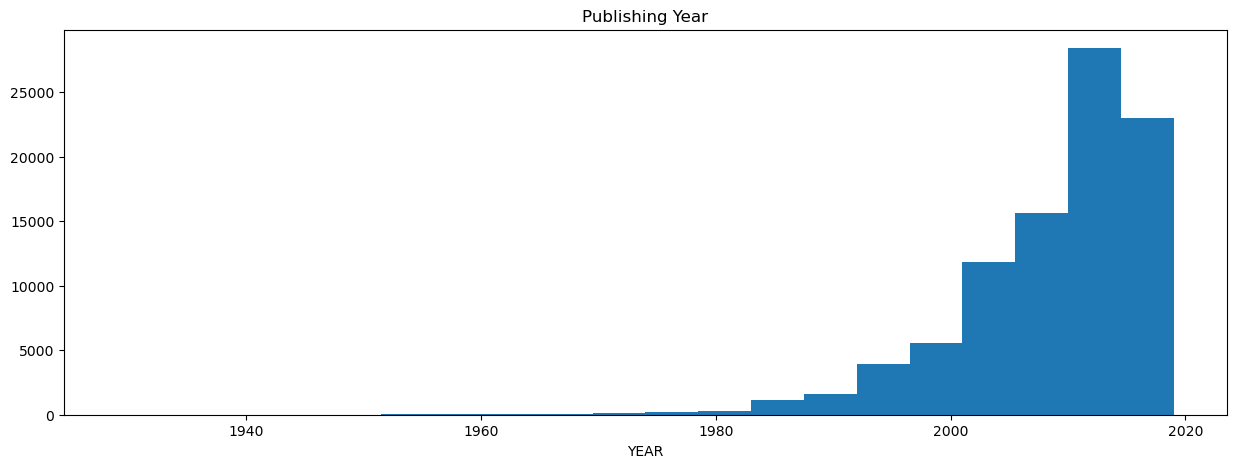

In [8]:
# Histogramm - Page Numbers
plot_three(data=df['PAGE_NUM'], title='Page Numbers', bins=40,  xlabel='PAGE_NUM', xlim=3000)

# Histogramm - Published Year
plt.figure(figsize=(15, 5))
plt.hist(df['PUBLISHED'], bins=20)
plt.title('Publishing Year')
plt.xlabel('YEAR')

# Authors
# Print 10 most common Authors
print('Most common Authors: ')
print(df['AUTHOR'].value_counts().head(50))

# Exploring the Topics

In [9]:

#all_topics = df['TOPICS'].str.split(',').explode().str.strip()
#df['TOPICS_SPLIT'] = df['TOPICS'].str.split(',').apply(lambda x: [i.strip() for i in x])
df['TOPICS_SPLIT'] = df['TOPICS'].apply(lambda x: sorted(list(set(i.strip() for i in re.split(r'[,\s]{2,}', x)))))
all_topics = df['TOPICS_SPLIT'].explode().str.strip()
topic_counts = Counter(all_topics)
dftopics = pd.DataFrame(topic_counts.items(), columns=['TOPICS', 'COUNT']).sort_values(by='COUNT', ascending=False)

print(f'Count Different Topics: {dftopics.shape[0]}')
print(f'\n25 Most Common Topics: ')
print(dftopics.head(25))
print(f'\n25 Least Common Topics: ')
print(dftopics.tail(25))

print(f'\nBook with most Topics:')
df.sort_values(by='TOPIC_COUNT', ascending=False).head(10)

Count Different Topics: 166

25 Most Common Topics: 
                           TOPICS  COUNT
1                      Nonfiction  34270
2                         Fiction  32812
5                Children’s Books  19792
8                        Suspense   9386
15                        Mystery   8856
6   Children’s Middle Grade Books   7728
32               Literary Fiction   7378
29                       Religion   7145
28                     Philosophy   7145
24                        Romance   6429
35                      Biography   5993
37                         Memoir   5993
54                       Thriller   5463
36                        History   4698
84                           Arts   4630
3                  Graphic Novels   4428
4                           Manga   4428
7              Historical Fiction   3956
62                       Classics   3877
9                            Teen   3754
30               Self-Improvement   3754
10                    Young Adult   3754
85  

,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE,TOPIC_COUNT,TOPICS_SPLIT
23873,Travels with a Donkey in the Cevennes and the ...,Robert Louis Stevenson,2005,9780141439464,320,https://www.penguinrandomhouse.com/books/28630...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"In 1878, Robert Louis Stevenson was suffering ...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
1288,Pictures from Italy,Charles Dickens,1998,9780140434316,272,https://www.penguinrandomhouse.com/books/26095...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,A delightful travelogue in the unique style of...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
76498,Italian Hours,Henry James,1995,9780140435078,416,https://www.penguinrandomhouse.com/books/29650...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"“The charm of certain vacant grassy spaces, in...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
21285,A Tramp Abroad,Mark Twain,1997,9780140436082,448,https://www.penguinrandomhouse.com/books/29654...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"Twain’s account of travelling in Europe, A TRA...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
89464,D. H. Lawrence and Italy,D. H. Lawrence,2008,9780141441559,528,https://www.penguinrandomhouse.com/books/32292...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,In these impressions of the Italian countrysid...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
6833,A Russian Journal,John Steinbeck,1999,9780141180199,240,https://www.penguinrandomhouse.com/books/35425...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,Steinbeck and Capa’s account of their journey ...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
23250,The World of Debbie Macomber: Come Home to Color,Debbie Macomber,2016,9780425286074,96,https://www.penguinrandomhouse.com/books/54610...,"Personal Growth, Art, Inspiration Motivation,...",(c) Penguin Random House,From beloved author and Hallmark Channel favor...,2018-08-18,en,9,"[Art, Arts, Crafts, Entertainment, Garden, Hob..."
61581,The Friendly Jane Austen,Natalie Tyler,2001,9781101191538,320,https://www.penguinrandomhouse.com/books/33169...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,What’s so friendly about Jane Austen?Every gen...,2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."
7400,Saint-exupery,Stacy Schiff,2011,9780307798398,522,https://www.penguinrandomhouse.com/books/16186...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,"From a master biographer, the life story of th...",2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."
22334,James Joyce,Edna O'Brien,1999,9781415910580,360,https://www.penguinrandomhouse.com/books/12315...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,One of Ireland’s best current novelists provid...,2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."


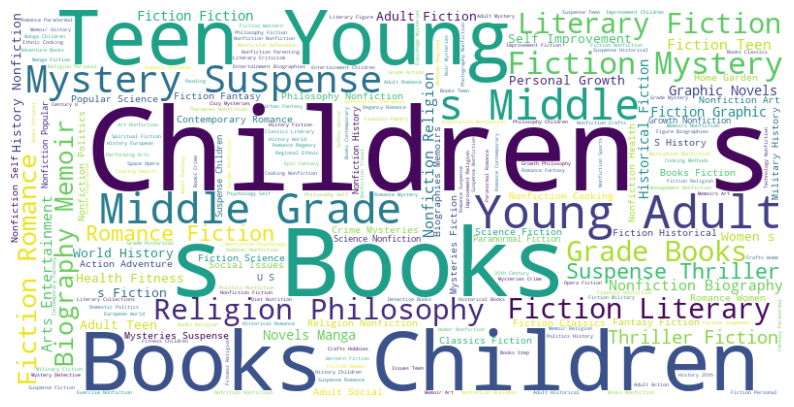

In [10]:
# Wordcloud
text = " ".join(df['TOPICS'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Label Clustering

## By Least Common Multiple (Kleinstes Gemeinsames Vielfaches)

In [11]:
# Find a minimum list of topics to cover all books
single_topic_df = df[df['TOPIC_COUNT'] == 1]
multi_topic_df = df[df['TOPIC_COUNT'] > 1]
single_topic_list = list(single_topic_df['TOPICS_SPLIT'].explode().unique())+['Young Adult']
topics_in_multi = multi_topic_df[multi_topic_df['TOPICS_SPLIT'].apply(lambda x: not any(topic in x for topic  in single_topic_list))]
if topics_in_multi.empty:
    print('All books can be covered by the topics: ', ', '.join(single_topic_list))
else:
    print(topics_in_multi)

# ALl Books that have more then one of this topics
print('Books with more then one of this topics: ')
mmulti_topic_df = df[df['TOPICS_SPLIT'].apply(lambda x: sum(topic in x for topic  in single_topic_list)>1)]
mmulti_topic_df

All books can be covered by the topics:  Fiction, Children’s Books, Nonfiction, Poetry, Humor, Classics, Young Adult
Books with more then one of this topics: 


,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE,TOPIC_COUNT,TOPICS_SPLIT
29,The BAP Handbook,"Ginger Wilson, Kalyn Johnson, Tracey Lewis, Ka...",2001,9780767905503,224,https://www.penguinrandomhouse.com/books/19187...,"Humor, Nonfiction, Reference",(c) Penguin Random House,"""Finally, a book about the Black American Prin...",2018-08-18,en,3,"[Humor, Nonfiction, Reference]"
35,Storyteller,Leslie Marmon Silko,2012,9780143121282,288,https://www.penguinrandomhouse.com/books/31015...,"Poetry, Fiction",(c) Penguin Random House,Now back in print—a classic work of Native Ame...,2018-08-18,en,2,"[Fiction, Poetry]"
51,The Complete Poems,John Keats,1977,9780140422108,752,https://www.penguinrandomhouse.com/books/26104...,"Classics, Poetry, Literary Collections",(c) Penguin Random House,The complete poems of an English masterKeats’s...,2018-08-18,en,3,"[Classics, Literary Collections, Poetry]"
56,Sensual Love Poems,Kathleen Blease,2002,9780345447876,176,https://www.penguinrandomhouse.com/books/14823...,"Classics, Poetry, Literary Criticism",(c) Penguin Random House,How does love speak? . . . In the embrace wher...,2018-08-18,en,3,"[Classics, Literary Criticism, Poetry]"
60,Archie Archives Volume 12,Various,2016,9781616557058,232,https://www.penguinrandomhouse.com/books/53717...,"Humor, Fiction, Graphic Novels Manga",(c) Penguin Random House,"If there’s trouble, Archie’s usually in the mi...",2018-08-18,en,3,"[Fiction, Graphic Novels, Humor, Manga]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91808,Be Sweet,"Roy Blount, Jr.",2013,9780307829719,288,https://www.penguinrandomhouse.com/books/15063...,"Literary Figure Biographies Memoirs, Arts En...",(c) Penguin Random House,In the book his laughing and loving readers ha...,2018-08-18,en,5,"[Arts, Biography, Entertainment Biographies, H..."
91816,Expensive People,Joyce Carol Oates,2006,9780812976540,256,https://www.penguinrandomhouse.com/books/12387...,"Classics, Fiction, Literary Fiction, Fiction C...",(c) Penguin Random House,Joyce Carol Oates’s Wonderland Quartet compris...,2018-08-18,en,5,"[Classics, Fiction, Fiction Classics, Historic..."
91862,Selected Poems,Pierre Ronsard,2002,9780140424249,384,https://www.penguinrandomhouse.com/books/27840...,"Classics, Poetry, Literary Collections",(c) Penguin Random House,Ronsard is considered one of France’s greatest...,2018-08-18,en,3,"[Classics, Literary Collections, Poetry]"
91868,Falling Into Place,Catherine Reid,2015,9780807061183,182,https://www.penguinrandomhouse.com/books/22672...,"Science, Classics, Nonfiction, Literary Collec...",(c) Penguin Random House,"Quietly powerful essays, weaving keenly observ...",2018-08-18,en,5,"[Classics, Literary Collections, Nonfiction, P..."


## Graphdatabase

Connecting all Topics that are listed for the same books

In [12]:
# Carful -> This takes a long time
if False:
    # Create Graph Database to visualize connections between topics
    uri = "bolt://localhost:7687"  # oder "neo4j://localhost:7687"
    username = "neo4j"
    password = "testpassword"

    # Verbindung zur Neo4j-Datenbank herstellen
    driver = GraphDatabase.driver(uri, auth=(username, password))

    def create_nodes_and_relationships(session, topics_list):
        for i, topic in enumerate(topics_list):
            session.run("MERGE (t:Topic {name: $name})", name=topic)

            for j in range(i + 1, len(topics_list)):
                session.run("""
                    MATCH (a:Topic {name: $name1}), (b:Topic {name: $name2})
                    MERGE (a)-[:CONNECTED_TO]-(b)
                """, name1=topic, name2=topics_list[j])

    with driver.session() as session:
        for topics_list in df['TOPICS_SPLIT']:
            create_nodes_and_relationships(session, topics_list)
        print("Graph created!")
#todo: Im Connection Feld die Anzahl der Verbindungen zählen --> eventuell kann man da dann Cluster raus finden

In [13]:
if False:
    # Topics with most conections to other Topics
    def get_node_with_most_edges(num=1):
        query = """
        MATCH (n:Topic)
        OPTIONAL MATCH (n)-[r]-()
        WITH n, (count(r) + count(r2)) AS num_relations
        ORDER BY num_relations DESC
        LIMIT {}
        RETURN n.name AS topic, num_relations
        """.format(num)

        with driver.session() as session:
            result = session.run(query)
            for record in result:
                print(f"Topic: {record['topic']}, Number of Relations: {record['num_relations']}")

    get_node_with_most_edges(20)
#todo: Da ist was falsch!!! Anzahl ist viel zu hoch - Es gibt nur 166 Nodes

## Label Clustering - ML Methods

In [14]:

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
os.environ['OMP_NUM_THREADS'] = '1'

# Load pretrained SBERT-Model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Embedding for every Topic
embeddings = model.encode(dftopics['TOPICS'].tolist())

# KMeans-Clustering
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
dftopics['CLUSTER_KMEANS'] = kmeans.fit_predict(embeddings)
clustered_topics = dftopics.groupby('CLUSTER_KMEANS')['TOPICS'].apply(list)
print('kMeans Clustering')
for cluster, topics in clustered_topics.items():
    print(f"Cluster {cluster}: {topics}")

# Agglomerative Clustering
agglom = AgglomerativeClustering(n_clusters=num_clusters, metric='cosine', linkage='average')
dftopics['CLUSTER_AGG'] = agglom.fit_predict(embeddings)
clustered_topics = dftopics.groupby('CLUSTER_AGG')['TOPICS'].apply(list)
print('\n\nAgglomerative Clustering')
for cluster, topics in clustered_topics.items():
    print(f"Cluster {cluster}: {topics}")

kMeans Clustering
Cluster 0: ['Suspense', 'Romance', 'Thriller', 'Contemporary Romance', 'Historical Romance', 'Suspense Romance', 'Paranormal Romance', 'Young Adult Romance', 'Regency Romance', 'Western Romance', 'New Adult Romance', 'Weddings']
Cluster 1: ['Travel', 'Travel: Europe', 'Travel Writing', 'Travel: USA', 'Specialty Travel', 'Travel: Asia', 'Travel: Central', 'Travel: Middle East', 'Travel: Caribbean', 'Travel: Africa', 'Travel: Australia']
Cluster 2: ['U.S. History', 'Regional', '20th Century U.S. History', 'Canada', 'Colonial/Revolutionary Period', '19th Century U.S. History', '21st Century U.S. History', 'North American World History', 'Native American History', 'South America', 'Mexico']
Cluster 3: ['Mystery', 'Crime Mysteries', 'Humor', 'Garden', 'Cozy Mysteries', 'Inspiration', 'Horror', 'Noir Mysteries', 'Adventure', 'Espionage Mysteries', 'Language', 'Wine', 'Beauty']
Cluster 4: ['Nonfiction', 'Memoir', 'Memoirs', 'Home', 'Adventure Books', 'Hobbies', 'Step Into Re

D:\Programme\miniconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Label Clustering Own Classification

In [65]:
#dftopics['TOPICS']
if 'CLUSTER_SELF' not in df.columns:
    df['CLUSTER_SELF'] = None

# History ... -> History
ddict = {'History':('History',), 'Mystery':('Mystery','Mysteries'),'Travel':('Travel',)}
for label, text in ddict.items():
    print(f'{tt} - Topics:')
    for tt in text:
        print(dftopics[dftopics['TOPICS'].str.contains(tt.lower(), case=False, na=False)]['TOPICS'])
        dftopics['TEMP'] = dftopics['TOPICS'].apply(lambda x: label if tt.lower() in x.lower() else None)
        dftopics['CLUSTER_SELF'] = dftopics.apply(lambda row: row['TEMP'] if pd.notna(row['TEMP']) else row['CLUSTER_SELF'], axis=1)
    #df.drop('TEMP', axis=1, inplace=True)
    print('\n')


#dftopics[dftopics['CLUSTER_SELF']]
dftopics[['TOPICS','CLUSTER_SELF']]

Travel - Topics:
36                             History
71                       World History
39                        U.S. History
97                    Military History
96              European World History
34           20th Century U.S. History
98       World War II Military History
131    1950 – Present Military History
70                 Asian World History
151       Middle Eastern World History
93           19th Century U.S. History
143          21st Century U.S. History
155              Ancient World History
146       North American World History
114       Latin American World History
159              African World History
145            Native American History
150       World War I Military History
Name: TOPICS, dtype: object


History - Topics:
15                            Mystery
22    Children’s Middle Grade Mystery
12                Young Adult Mystery
Name: TOPICS, dtype: object
14         Crime Mysteries
19          Cozy Mysteries
53          Noir Mysteries
108    Esp

,TOPICS,CLUSTER_SELF
1,Nonfiction,None
2,Fiction,None
5,Children’s Books,None
8,Suspense,None
15,Mystery,Mystery
...,...,...
161,Travel: Caribbean,Travel
165,Travel: Africa,Travel
157,Bibles,None
163,Oceania,None


# Exploring the Blurbs


In [47]:
# Print First 5 Blurb
for val in df['DESCRIPTION'][0:10]:
    print(val)
    print('-------------------')
# First: Here missing \t \n \r ... --> Words are sticked together
# Includes often not only information of the story but of the author, version,...

Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential to each day as the first cup of coffee in the morning. Now, for the first time ever, these premier puzzles are available in six clever installments. With each day of the week, the puzzles increase gradually in skill level; Monday’s the easiest, but Saturday’s sure to challenge! Push your mental muscles a little harder each day with America’s favorite sophisticated — and fun — pastime: the New York Times crossword puzzles!The legendary Eugene T. Maleska was crossword editor of The New York Times from 1977 to 1993.
-------------------
Two of literary comics modern masters present a pair of magical and disturbing stories of strange creatures who are not quite what they seem! In The Price, a mysteri

In [48]:
# Count Words in Blurb
dfb = df[['DESCRIPTION']].copy()

dfb['DESCRIPTION_LOWER'] = dfb['DESCRIPTION'].str.lower()
dfb['DESCRIPTION_SPLIT'] = dfb['DESCRIPTION_LOWER'].str.split()
dfb['WORD_COUNT'] = dfb['DESCRIPTION_SPLIT'].apply(len)
dfb['SENTENCE_COUNT'] = dfb['DESCRIPTION'].str.count('\.') + dfb['DESCRIPTION'].str.count('\!') + dfb['DESCRIPTION'].str.count('\?')

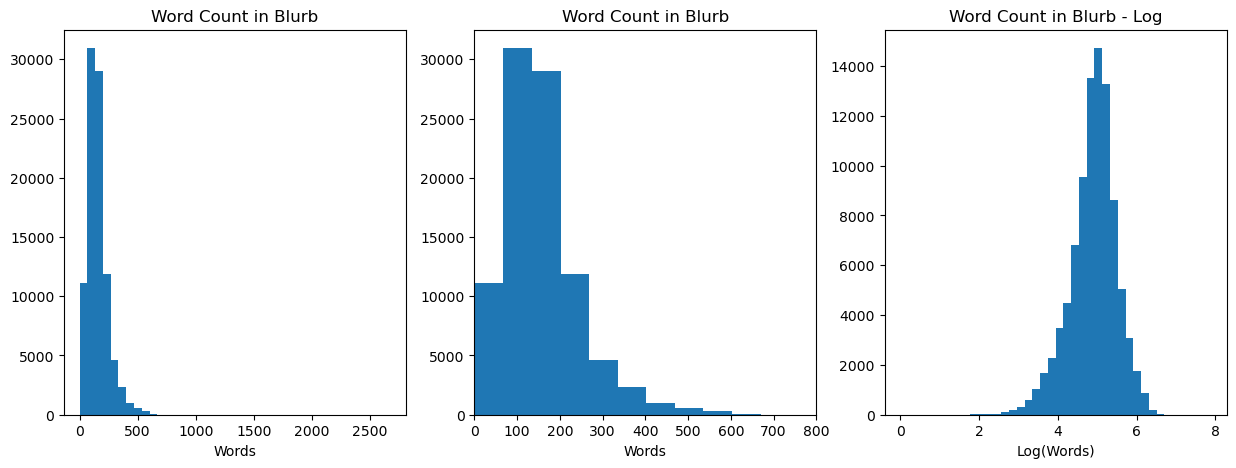

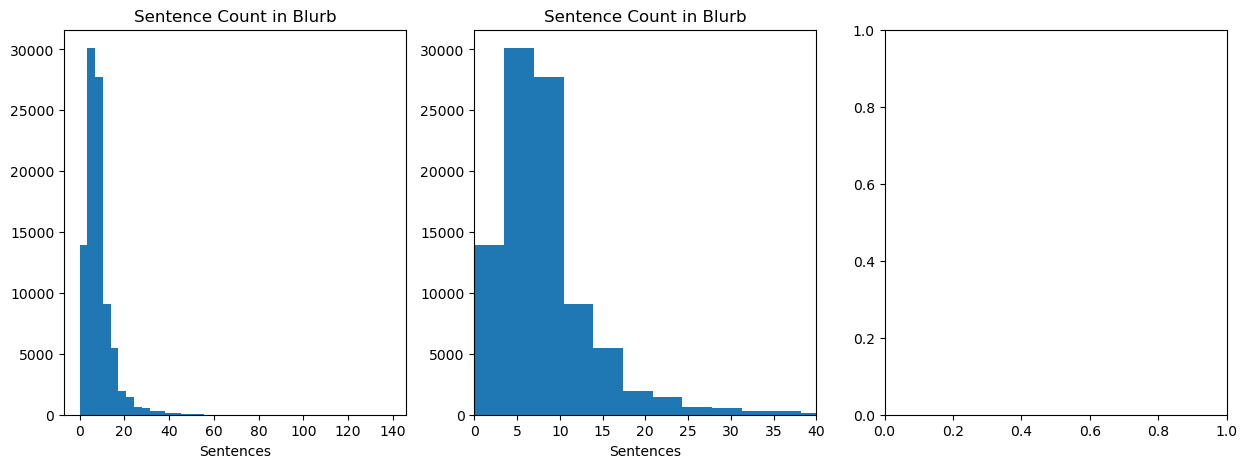

In [49]:
# Histogram Word COunt
plot_three(data=dfb['WORD_COUNT'], title='Word Count in Blurb', bins=40,  xlabel='Words', xlim=800)

# Histogram Sentence Count
plot_two(data=dfb['SENTENCE_COUNT'], title='Sentence Count in Blurb', bins=40,  xlabel='Sentences', xlim=40)

In [50]:
# Longest Blurb
dfb.loc[dfb['SENTENCE_COUNT'].idxmax(), 'DESCRIPTION']

'THE NEW YORK TIMES BESTSELLERPulitzer Prize-winning author of A Thousand Acres"Rousing . . . Action-packed . . . A gripping story about love, fortitude, and convictions that are worth fighting for."—Los Angeles TimesA NEW YORK TIMES NOTABLE BOOK"POWERFUL . . . Smiley takes us back to Kansas in 1855, a place of rising passions and vast uncertainties. Narrated in the spirited, unsentimental voice of 20-year-old Lidie Newton, the novel is at once an ambitious examination of a turning point in history and the riveting story of one woman’s journey into uncharted regions of place and self."—Chicago Tribune"[A] grand tale of the moral and political upheavals igniting antebellum frontier life and a heroine so wonderfully fleshed and unforgettable you will think you are listening to her story instead of reading it. Smiley may have snared a Pulitzer for A Thousand Acres . . . but it is with Lydia (Lidie) Harkness Newton that she emphatically captures our hearts. . . . The key word in Smiley’s t

In [71]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Romina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Romina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Romina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [57]:
# Remove Stopwords, Tokenization and Stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())  # Lowercasing and tokenizing
    # Removing stop words and non-alphabetical characters
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Applying stemming on the filtered tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return " ".join(stemmed_tokens)
# Apply preprocessing to the book descriptions
dfb['DESCRIPTION_CLEAN'] = dfb['DESCRIPTION'].apply(preprocess_text)




In [58]:
dfb['DESCRIPTION_CLEAN'].head()

0    monday crossword easetuesday crossword breezew...
1    two literari comic modern master present pair ...
2    cornelia daughter two legaci feel fabul instea...
3    english age reason woman cloister sinc birth l...
4    retel strang case jekyl hyde chill twist harpe...
Name: DESCRIPTION_CLEAN, dtype: object

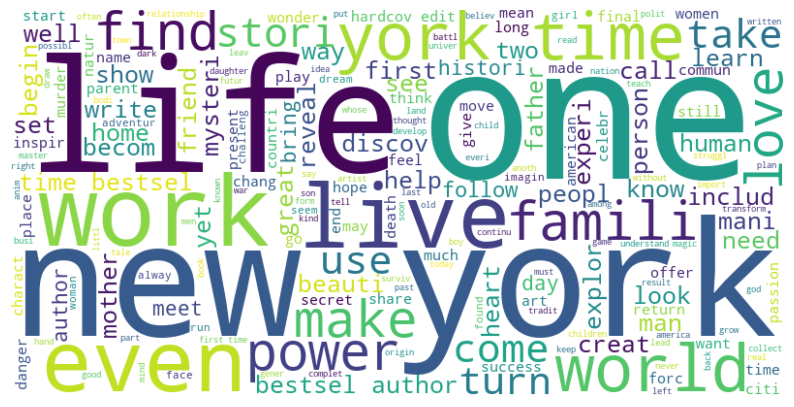

In [54]:
# Wordcloud
text = " ".join(dfb['DESCRIPTION_CLEAN'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Trying out some models

## Logistic Regression


In [74]:
# One Hot Encoding of Labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['TOPICS_SPLIT'])
#y = pd.DataFrame(genre_onehot, columns=mlb.classes_)


In [73]:
# TF-IDF Vektorising --> transform to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dfb['DESCRIPTION_CLEAN'])

In [75]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f'Train X Size: {X_train.shape}')
print(f'Test X Size: {X_test.shape}')
print(f'Train Y Size: {y_train.shape}')
print(f'Test Y Size: {y_test.shape}')

Train X Size: (73515, 5000)
Test X Size: (18379, 5000)
Train Y Size: (73515, 146)
Test Y Size: (18379, 146)


In [76]:
classifier = LogisticRegression(max_iter=1000)

multi_classifier = MultiOutputClassifier(classifier)
multi_classifier.fit(X_train, y_train)
y_pred = multi_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                                  precision    recall  f1-score   support

                 1950 – Present Military History       0.92      0.24      0.38        50
                       19th Century U.S. History       0.00      0.00      0.00        32
                       20th Century U.S. History       0.67      0.02      0.04        90
                       21st Century U.S. History       0.00      0.00      0.00        20
                           African World History       0.00      0.00      0.00         9
                           Alternative Therapies       0.75      0.43      0.55       202
                           Ancient World History       0.00      0.00      0.00        23
                                             Art       0.86      0.58      0.69       296
                             Arts  Entertainment       0.89      0.51      0.64       777
        Arts  Entertainment Biographies  Memoirs       0.79      0.15      0.26       297
         

D:\Programme\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programme\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programme\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

In [ ]:

# Modell laden
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training Arguments definieren
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

# Trainer definieren
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset            # evaluation dataset
)

# Modell trainieren
trainer.train()
